# Correlaciones

* El diversificar correctamente una cartera es muy importante.
* Las estrategias de trade son complicadas, es decir, los momentos oportunos de entrada/salida no son muy precisos.

* Dado un portfolio de activos, armar la cartera de menor volatilidad (solo long positions)

* Extender el concepto de volatilidad a semivolatilidad (no realizado en este TP)

* Implementar Sortino (como reemplazo de semivolatilidad)

In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_tickers = list(sp500.Symbol)

sp500_tickers = [e for e in sp500_tickers if e not in ('BRK.B','BF.B')]

sp500_tickers=sp500_tickers[:2] # los primeros 2
print(sp500_tickers)

cierres = yf.download(sp500_tickers, start='2000-01-01')['Adj Close']
cierres = cierres.loc[:, (cierres != 0).all(axis=0)]

['MMM', 'ABT']
[*********************100%***********************]  2 of 2 completed


In [2]:
rets = np.log((cierres/cierres.shift(1)))

weights=np.random.random(len(sp500_tickers))
weights=weights/np.sum(weights)

# Retorno, covarianza y std del portfolio inicial
exp_ret=np.sum(rets.mean()*weights)*252
exp_cov=np.dot(weights.T,np.dot(rets.cov()*252,weights))
exp_std=np.sqrt(np.dot(weights.T,np.dot(rets.cov()*252,weights)))

In [3]:
prets=[]
pvols=[]
pweights=[]

for p in range(1000): # numero de simulaciones
    
    weights=np.random.random(len(sp500_tickers))
    weights /= np.sum(weights)
    
    prets.append(np.sum(rets.mean()*weights)*252)
    pvols.append(np.sqrt(np.dot(weights.T,np.dot(rets.cov()*252,weights))))
    pweights.append(list(weights))
    
    
df=pd.DataFrame(pweights,columns=sp500_tickers)    
df['prets']=prets
df['pvols']=pvols

ordenado=df.sort_values(by='pvols',ascending=True)

In [4]:
a=0
for ticker in sp500_tickers:
    print('Weight de ', ticker, ' = ',round(ordenado.iloc[0,a]*100,1),' %')
    a+=1

print('\nRendimiento del portfolio ', round(ordenado.iloc[0,a]*100,2), ' %')
print('Volatilidad del portfolio ', round(ordenado.iloc[0,a+1]*100,2), ' %')

Weight de  MMM  =  48.5  %
Weight de  ABT  =  51.5  %

Rendimiento del portfolio  11.04  %
Volatilidad del portfolio  20.27  %


In [5]:
rendimientos=rets.mean()
desvios=rets.std()
tasaRF=0.015/360

tablaRatios=pd.DataFrame(index=rets.columns)
tablaRatios['sharpeDiario']=(rendimientos-tasaRF)/desvios
tablaRatios['sharpeAnualizado']=tablaRatios.sharpeDiario*250**0.5

sortinos=[]

In [8]:
for activo in sp500_tickers:
    
    filtro=rets[activo].loc[rets[activo]<0]
    desvioNeg=filtro.std()
    sortinos.append((rendimientos[activo]-tasaRF)/desvioNeg)
    

In [9]:
tablaRatios['sortinoDiario']=sortinos
tablaRatios['sortinoAnualizado']=tablaRatios.sortinoDiario*250**0.5
print('\n',tablaRatios)


ordenadoSortino=tablaRatios.sort_values(by='sortinoAnualizado',ascending=False)
print('\n',ordenadoSortino)


      sharpeDiario  sharpeAnualizado  sortinoDiario  sortinoAnualizado
ABT      0.031381          0.496170       0.027119           0.428792
MMM      0.020795          0.328805       0.041406           0.654689

      sharpeDiario  sharpeAnualizado  sortinoDiario  sortinoAnualizado
MMM      0.020795          0.328805       0.041406           0.654689
ABT      0.031381          0.496170       0.027119           0.428792


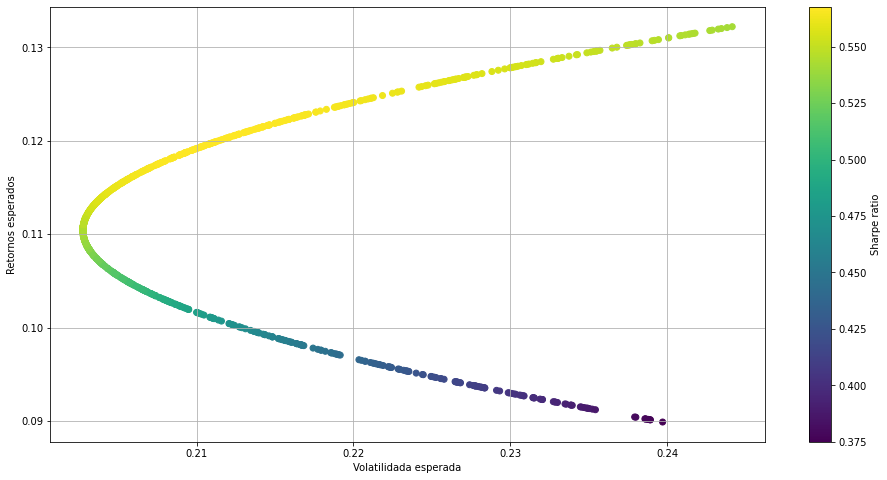

In [10]:
prets = np.array(prets)
pvols=np.array(pvols)

plt.figure(figsize=(16,8))
plt.scatter(pvols, prets,c=prets / pvols,marker='o')
plt.grid(True)
plt.xlabel('Volatilidada esperada')
plt.ylabel('Retornos esperados')
plt.colorbar(cmap='plasma', label='Sharpe ratio')
plt.show()

# Capacidad predictiva

* Definir indicadores (macd-ret-cruce)
* En base a los 3 indicadores, inferir si existe correlacion con precio futuro (fw)
* Aceptar/rechazar correlacion en base a salida grafica.

In [11]:
fast = 20
slow = 50
ventana = 5 # es el precio a 5 dias - el rolling de 250 es la ventana anual

for ticker in sp500_tickers:
    
    cierres[ticker+'_macd'] = cierres[ticker].ewm(span=fast).mean()    
    - cierres[ticker].ewm(span=slow).mean()
    
    
    cierres[ticker+'_ret']=np.log((cierres[ticker]/cierres[ticker].shift(1)))
    
    cierres[ticker+'_cruce']=(cierres[ticker].rolling(fast).mean()/
                              cierres[ticker].rolling(slow).mean() - 1) * 100
    
    cierres[ticker+'_fw'] = cierres[ticker].shift(-ventana) / cierres[ticker]

cierres=cierres.dropna()

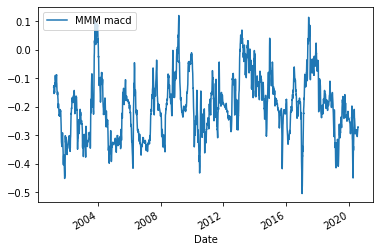

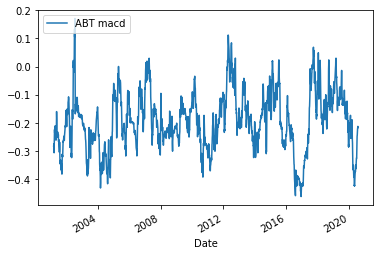

In [12]:
for ticker in sp500_tickers:
    cierres[ticker+'_macd'].rolling(250).corr(cierres[ticker+'_fw']).plot()
    plt.legend([ticker+' macd'],loc='upper left')
    plt.show()

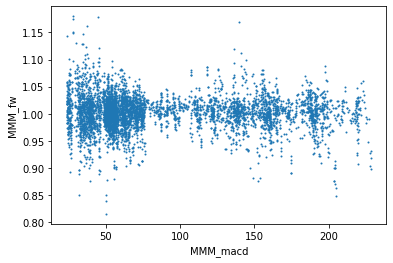

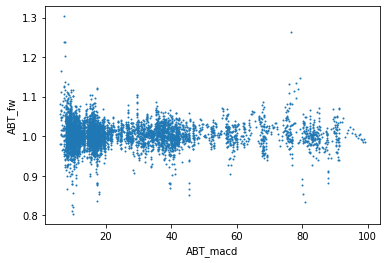

In [13]:
for ticker in sp500_tickers:
    cierres.plot(ticker+'_macd',ticker+'_fw', s=1, kind='scatter')

MACD conclusion

* el rolling correlation sugiere algun marco temporal donde se logran valores de correlacion cercanos a -0.4
* el scatter plot desestima capacidad de predeccion, ya que frente a variaciones de macd el futuro no cambia.

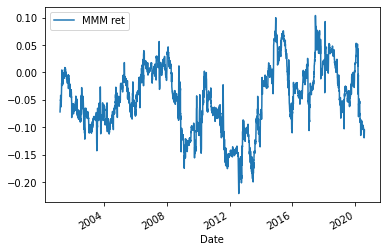

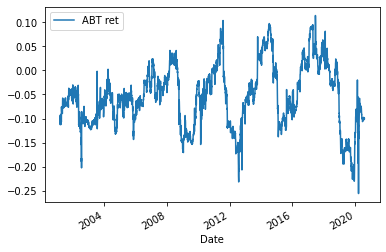

In [14]:
for ticker in sp500_tickers:

    cierres[ticker+'_ret'].rolling(250).corr(cierres[ticker+'_fw']).plot()
    plt.legend([ticker+' ret'],loc='upper left')
    plt.show()

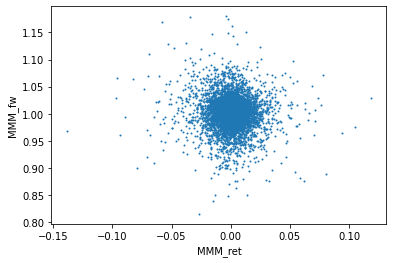

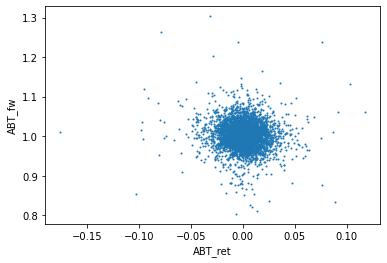

In [15]:
for ticker in sp500_tickers:

    cierres.plot(ticker+'_ret',ticker+'_fw', s=1, kind='scatter')

RET conclusion (prospectos de inversion: **rendimiento del pasado no garantiza rendimiento futuro**)

* el rolling correlation no sugiere ninguna correlacion.
* el scatter plot no sugiere ninguna correlacion.

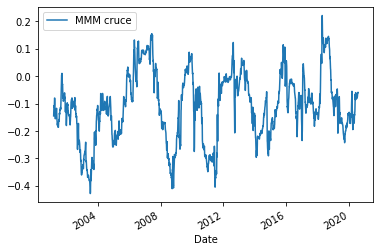

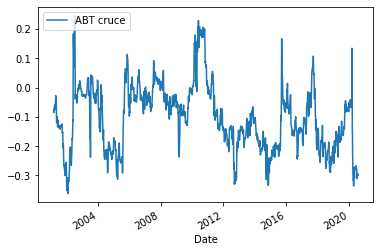

In [16]:
for ticker in sp500_tickers:
    cierres[ticker+'_cruce'].rolling(250).corr(cierres[ticker+'_fw']).plot()
    plt.legend([ticker+' cruce'],loc='upper left')
    plt.show()

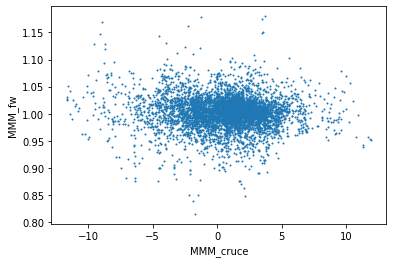

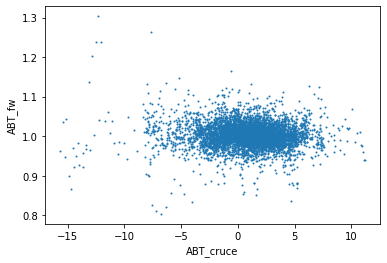

In [17]:
for ticker in sp500_tickers:

    cierres.plot(ticker+'_cruce',ticker+'_fw', s=1, kind='scatter')

CRUCE conclusion

* el rolling correlation no sugiere algun marco temporal donde se logran valores de correlacion aceptables
* el scatter plot desestima capacidad de predeccion, ya que frente a variaciones de cruce el futuro no cambia.